<a href="https://colab.research.google.com/github/MatiTaila/hack_iia/blob/ia-2003/image_clasification/Clasificacion%20de%20imagenes%20con%20Red%20Neuronal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de imágenes con Red Neuronal

La idea de este ejercicio es realizar la misma clasificación que hicimos con kNN sobre `CIFAR10`, pero utilizando una red neuronal de 2 capas implementada en `Python`.

## Mount Drive, set direcotries and imports

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
import os
os.chdir('/content/drive/My Drive/hack_iia/image_clasification/')  #change dir
!pwd

/content/drive/My Drive/hack_iia/image_clasification


In [0]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Red neuronal de dos capas

Implementación de una red neuronal totalmente conectada (Fully Connected - FC) 

La capa de entrada tiene dimensión `N`, la capa oculta `H` y realiza una clasificación en `C` clases.

Vamos a entrenar una red con `SoftMax Loss`, y `ReLu`.

En otras palabras, la red tendrá la siguiente arquitectura:

```
entrada - capa totalmente conectada - ReLU - capa totalmente conectada - SoftMax
```

Las salidas de la segunda capa totalmente conectada representan los puntajes para cada clase


In [0]:
class TwoLayerNet(object):

  def __init__(self, input_size, hidden_size, output_size, std=1e-4):
    self.params = {}
    self.params['W1'] = std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] = std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)

  def loss(self, X, y=None, reg=0.0):
    W1, b1 = self.params['W1'], self.params['b1']
    W2, b2 = self.params['W2'], self.params['b2']
    N, D = X.shape

    # Forward pass
    scores = None

    XW1 = np.dot(X, W1)
    XW1pb1 = XW1 + b1
    H1 = np.maximum(XW1pb1, 0)

    H1W2 = np.dot(H1, W2)
    scores = H1W2 + b2

    if y is None:
      return scores

    # Loss
    loss = None
    scores -=  np.max(scores)
    q = np.exp(scores) / np.sum(np.exp(scores), axis=1, keepdims=True)
    loss = np.sum(-np.log(q[np.arange(N), y])) / N + 0.5 * reg * (np.sum(W1 * W1) + np.sum(W2 * W2))

    # Backward pass: calculo de gradientes
    grads = {}    
    dscores = q
    dscores[range(N), y] -= 1
    dscores /= N
    
    # scores = H1W2 + b2
    dH1W2 = dscores
    db2 = np.sum(dscores, axis=0)
    # H1W2 = np.dot(H1, W2)
    dH1 = dH1W2.dot(W2.T)
    dW2 = H1.T.dot(dH1W2)
    # H1 = np.maximum(0, XW1pb1)
    dXW1pb1 = dH1
    dXW1pb1[XW1pb1 < 0] = 0
    # XW1pb1 = XW1 + b1
    dXW1 = dXW1pb1
    db1 = np.sum(dXW1pb1, axis=0)
    # XW1 = np.dot(X, W1)
    dW1 = X.T.dot(dXW1)

    grads['W1'] = dW1 + reg * W1
    grads['b1'] = db1
    grads['W2'] = dW2 + reg * W2
    grads['b2'] = db2
    
    return loss, grads

  def train(self, X, y, X_val, y_val,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):

    num_train = X.shape[0]
    iterations_per_epoch = max(num_train / batch_size, 1)

    # Descenso por gradiente
    loss_history = []
    train_acc_history = []
    val_acc_history = []

    for it in range(num_iters):
      X_batch = None
      y_batch = None

      idxs = np.random.choice(num_train, batch_size)
      X_batch = X[idxs, :]
      y_batch = y[idxs]

      # Calculo del Loss y de los gradientes para el minibatch actual
      loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
      loss_history.append(loss)

      self.params['W1'] = self.params['W1'] - learning_rate * grads['W1']
      self.params['b1'] = self.params['b1'] - learning_rate * grads['b1']
      self.params['W2'] = self.params['W2'] - learning_rate * grads['W2']
      self.params['b2'] = self.params['b2'] - learning_rate * grads['b2']

      if verbose and it % 100 == 0:
        print('iteracion %d / %d: loss %f' % (it, num_iters, loss))

      # Ajuste del learning rate
      if it % iterations_per_epoch == 0:
        # Checkeo de precision
        train_acc = (self.predict(X_batch) == y_batch).mean()
        val_acc = (self.predict(X_val) == y_val).mean()
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        # Reducción del learning rate
        learning_rate *= learning_rate_decay

    return {
      'evolucion_loss': loss_history,
      'evolucion_precision_entrenamiento': train_acc_history,
      'evolucion_precision_validacion': val_acc_history,
    }

  def predict(self, X):
    y_pred = None
    W1, b1 = self.params['W1'], self.params['b1']
    W2, b2 = self.params['W2'], self.params['b2']
    scores = np.dot(np.maximum(0, np.dot(X, W1) + b1), W2) + b2
    y_pred = np.argmax(scores, axis=1)

    return y_pred

## Cargamos los datos

In [8]:
from data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):

    # Cargados de datos
    cifar10_dir = 'cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Sub-muestreo
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalización
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Cambio de dimensiones
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Tamaño de datos de entrenamiento: ', X_train.shape)
print('Tamaño de etiquetas de entrenamiento: ', y_train.shape)
print('Tamaño de datos de validación: ', X_val.shape)
print('Tamaño de etiquetas de validación: ', y_val.shape)
print('Tamaño de datos de test: ', X_test.shape)
print('Tamaño de etiquetas de test: ', y_test.shape)

Tamaño de datos de entrenamiento:  (49000, 3072)
Tamaño de etiquetas de entrenamiento:  (49000,)
Tamaño de datos de validación:  (1000, 3072)
Tamaño de etiquetas de validación:  (1000,)
Tamaño de datos de test:  (1000, 3072)
Tamaño de etiquetas de test:  (1000,)


## Entrenamiento

Tiene algunos detalles, como utilizar un descenso de gradiente estocástico con "momentum", e ir adaptando el `learning rate` exponencialmente, y ajustado después de cada época.

### ¿Por qué será necesario ir ajustando el `learning rate`?

Con learning rates bajos, vamos a avanzar muy lento en el descenso por gradiente, logrando mejoras lentas. El loss decaerá más o menos de forma lineal. Por otro lado, con learning rates grandes veremos un decaimiento del loss con forma exponencial. Si es demasiado grande, el loss quedará estancado en un valor más alto, ya que los parámetros quedarán "saltando", sin lograr encontrar un punto de estabilidad. Una buena estrategia es entonces empezar con un learning rate grande para dar los saltos más grandes rápidamente, y a medida que buscamos una solución más exacta ir disminuyendo el paso para lograr una mejor estabilidad.


In [9]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Entrenamiento
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1500, batch_size=200,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=0.7, verbose=True)

# Predicción en el set de validación
val_acc = (net.predict(X_val) == y_val).mean()
print('Precisión en validación: ', val_acc)

iteracion 0 / 1500: loss 2.303129
iteracion 100 / 1500: loss 1.927290
iteracion 200 / 1500: loss 1.874696
iteracion 300 / 1500: loss 1.760527
iteracion 400 / 1500: loss 1.675683
iteracion 500 / 1500: loss 1.612468
iteracion 600 / 1500: loss 1.527490
iteracion 700 / 1500: loss 1.542435
iteracion 800 / 1500: loss 1.658293
iteracion 900 / 1500: loss 1.563427
iteracion 1000 / 1500: loss 1.584386
iteracion 1100 / 1500: loss 1.472119
iteracion 1200 / 1500: loss 1.558864
iteracion 1300 / 1500: loss 1.487200
iteracion 1400 / 1500: loss 1.431875
Precisión en validación:  0.478


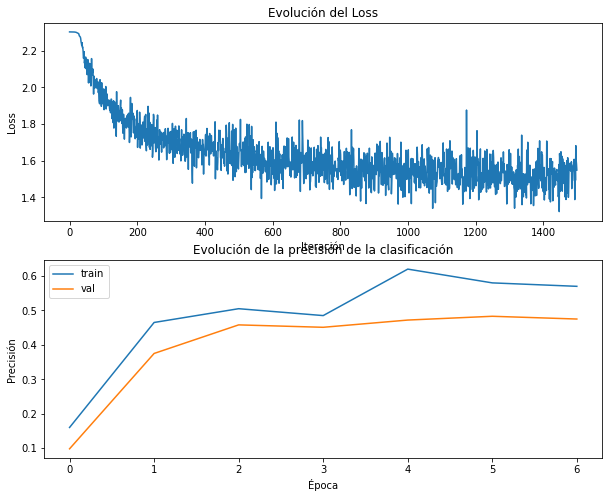

In [10]:
# Grafica de la evolución del Loss y de la precisión
plt.subplot(2, 1, 1)
plt.plot(stats['evolucion_loss'])
plt.title('Evolución del Loss')
plt.xlabel('Iteración')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['evolucion_precision_entrenamiento'], label='train')
plt.plot(stats['evolucion_precision_validacion'], label='val')
plt.title('Evolución de la precisión de la clasificación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.show()

In [11]:
test_acc = (net.predict(X_test) == y_test).mean()
print('Precisión en el conjunto de test: ', test_acc)

Precisión en el conjunto de test:  0.476


## ¡FIN!